# **Stock Prices Predictions with Machine Learning**

This Notebook will contain the modeling phases needed to predict stock prices using a deep learning model.
The stocks analyzed will be the following:
* IBM
* AAPL (Apple Inc.)
* AMZN (Amazon Inc.)
* GOOGL (Alphabet Inc.)


In [197]:
import os

In [ ]:
import sagemaker

# Data preparation

Data must be prepared in order to be processed by DeepAR model:
* Train/test set split
* Save Data locally
* Upload to S3

In [198]:
data_dir = 'stock_deepar'

### JSON serialization

In order to feed DeepAR model, JSON files must be prepared from data.
I'll create two kind of JSON inputs with the following "dynamic features":
* Open,
* 20 days windowed moving average,
* 20 days windowed bollinger band low value,
* 20 days windowed bollinger band high value.

#### DataFrame to JSON conversion

Now I'm going to convert data to JSON file format, in order to feed the DeepAR model correctly.

As already announced, I will create two kind of time series, one with a list of dynamic features `dyn_feat`and the other one with only the target column (`Adj Close`) time series. 

In [199]:
# initializing train/test dataframe lists to iterate on them
dfs_train = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
dfs_test = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]
dfs_valid = [df_ibm_valid, df_aapl_valid, df_amzn_valid, df_googl_valid]

Creating local storage path:

In [200]:
data_dir_json = os.path.join(data_dir, 'json')
if not os.path.exists(data_dir_json): # Make sure that the folder exists
    os.makedirs(data_dir_json)

Serializing data to json files

In [ ]:
from source_deepar.deepar_utils import ts2DeepARjson_serialize

Dataset with the `Adj Close` time series alone:

Dataset containing dynamic features:

Training data:

In [202]:
data_dir_json_dyn_feat = os.path.join(data_dir_json, 'w_dyn_feat')

In [203]:
data_dir_json_train_dyn_feat = os.path.join(data_dir_json_dyn_feat, 'train') # The folder we will use for storing data
if not os.path.exists(data_dir_json_train_dyn_feat): # Make sure that the folder exists
    os.makedirs(data_dir_json_train_dyn_feat)

In [ ]:
for df, m in zip(dfs_train, mnemonics):
    ts2DeepARjson_serialize(df, data_dir_json_train_dyn_feat, m+'.json', dyn_feat=['Open', '20_ac_bb_l', '20_ac_ma', '20_ac_bb_u'])

Test data:

In [238]:
data_dir_json_test_dyn_feat = os.path.join(data_dir_json_dyn_feat, 'test') # The folder we will use for storing data
if not os.path.exists(data_dir_json_test_dyn_feat): # Make sure that the folder exists
    os.makedirs(data_dir_json_test_dyn_feat)

In [239]:
for df, m in zip(dfs_test, mnemonics):
    ts2DeepARjson_serialize(df, data_dir_json_test_dyn_feat, m+'.json', dyn_feat=['Open',  '20_ac_bb_l', '20_ac_ma', '20_ac_bb_u'])

Validation data:

In [240]:
data_dir_json_valid_dyn_feat = os.path.join(data_dir_json_dyn_feat, 'validation') # The folder we will use for storing data
if not os.path.exists(data_dir_json_valid_dyn_feat): # Make sure that the folder exists
    os.makedirs(data_dir_json_valid_dyn_feat)

In [241]:
for df, m in zip(dfs_valid, mnemonics):
    ts2DeepARjson_serialize(df, data_dir_json_valid_dyn_feat, m+'.json', dyn_feat=['Open', '20_ac_bb_l', '20_ac_ma', '20_ac_bb_u'])

### Set DeepAR specific hyperparameters

In [466]:
from source_deepar import deepar_utils

In [1]:
# setting target columns
target_column = 'Adj Close'

In [2]:
# DeepAR estimator parameters    
hyperparameters = {
    "prediction_length": str(prediction_length[1]), #number of time-steps model is trained to predict, always generates forecasts with this length
    "context_length": str(context_length[1]), #number of time-points that the model gets to see before making the prediction, should be about same as the prediction_length
    "time_freq": interval, #granularity of the time series in the dataset
    "epochs": "200", #maximum number of passes over the training data
    "early_stopping_patience": "40", #training stops when no progress is made within the specified number of epochs
    "num_layers": "2", #number of hidden layers in the RNN, typically range from 1 to 4    
    "num_cells": "40", #number of cells to use in each hidden layer of the RNN, typically range from 30 to 100
    "mini_batch_size": "128", #size of mini-batches used during training, typically values range from 32 to 512
    "learning_rate": "1e-3", #learning rate used in training. Typical values range from 1e-4 to 1e-1
    "dropout_rate": "0.1", # dropout rate to use for regularization, typically less than 0.2. 
    "likelihood": "gaussian" #noise model used for uncertainty estimates - gaussian/beta/negative-binomial/student-T/deterministic-L1
}

NameError: name 'prediction_length' is not defined

## Estimator Instantiation

In [469]:
from sagemaker.estimator import Estimator

# instantiate a DeepAR estimator
estimator = Estimator(image_uri=image_name,
                      sagemaker_session=sagemaker_session,
                      #image_name=image_name,
                      role=role,
                      instance_count=1,
                      instance_type='ml.c4.xlarge',
                      output_path=s3_output_path,
                      hyperparameters=hyperparameters
                      )

## Training Job Creation

Creation of a training job with dynamic feature included time series. Run only if no model has already been trained before.

In [ ]:
%%time
# train and test channels
data_channels = {
    "train": input_data_train_dyn_feat,
    "test": input_data_test_dyn_feat
}

# fit the estimator
estimator.fit(inputs=data_channels)

## Existing Model Instantiation

Instatiation of a model from existing training artifacts (run only if a model has already been trained before).

In [208]:
model = sagemaker.model.Model(
    model_data='{}/{}/model.tar.gz'.format(s3_output_path, 'forecasting-deepar-2021-03-14-20-25-17-122/output'),
    image_uri= image_name,
    #image=image_name,  # example path for the semantic segmentation in eu-west-1
    role=role)  # your role here; could be different name

#trainedmodel.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

## Deploy and Create a Predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to a predictor endpoint.

Remember to **delete the endpoint** at the end of this notebook. A cell at the very bottom of this notebook will be provided, but it is always good to keep, front-of-mind.

In [496]:
endpoint_name = 'DeepAR-ml-spp-dyn-feat'

In [497]:
# create a predictor

from sagemaker.predictor import json_serializer, json_deserializer

In [498]:
# run it once, then update the endpoint if needed
%time

endpoint = model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name=endpoint_name,
    #content_type="application/json" # specify that it will accept/produce JSON
    # update_endpoint=True, # deprecated
    serializer=json_serializer,
    deserializer=json_deserializer
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
-----------------!

update endpoint if needed:

In [ ]:
%time

# update an endpoint

predictor = estimator.update_endpoint(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
)

Creating a predictor capable to process dataframes and return dataframes.

In [499]:
from source_deepar.deepar_utils import DeepARPredictor

In [500]:
json_predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
json_predictor.set_prediction_parameters(interval, prediction_length[1])

# Generating Predictions

According to the [inference format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html) for DeepAR, the `predictor` expects to see input data in a JSON format, with the following keys:
* **instances**: A list of JSON-formatted time series that should be forecast by the model.
* **configuration** (optional): A dictionary of configuration information for the type of response desired by the request.

Within configuration the following keys can be configured:
* **num_samples**: An integer specifying the number of samples that the model generates when making a probabilistic prediction.
* **output_types**: A list specifying the type of response. We'll ask for **quantiles**, which look at the list of num_samples generated by the model, and generate [quantile estimates](https://en.wikipedia.org/wiki/Quantile) for each time point based on these values.
* **quantiles**: A list that specified which quantiles estimates are generated and returned in the response.


Below is an example of what a JSON query to a DeepAR model endpoint might look like.

```
{
 "instances": [
  { "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0] },
  { "start": "1999-01-30", "target": [2.0, 1.0] }
 ],
 "configuration": {
  "num_samples": 50,
  "output_types": ["quantiles"],
  "quantiles": ["0.5", "0.9"]
 }
}
```

## Get Predictions

We can now use the model to get a predictions for input time series.

### Predicting IBM stock price

Ground truth:

In [546]:
test_gt = df_ibm_test.iloc[-prediction_length[1]:]['Adj Close']

In [547]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_ibm_train]
target_ts = [df_ibm]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)

In [548]:
json_prediction[0]

,0.1,0.9,0.5
2021-01-14,123.024529,129.072327,126.191551
2021-01-15,123.096985,129.226898,125.628563
2021-01-16,120.895729,129.058823,125.415184
2021-01-17,121.093140,128.857910,124.770340
2021-01-18,119.944328,128.903595,124.652054
2021-01-19,121.230835,129.714706,125.400627
2021-01-20,119.496040,128.474976,124.678207
2021-01-21,120.044586,129.188797,124.651932
2021-01-22,119.537109,129.696350,124.367767
2021-01-23,119.245842,129.951706,124.477402


As we can see, index are just progressing of one day each row, wich is not stock price progression scheme in real life (e.g.: weekends are not trading days), so I'm going fix the index before going on with the analysis of results:

In [549]:
single_prediction = json_prediction[0]

In [550]:
single_prediction.index = test_gt.index

Save data locally:

In [551]:
data_dir_json_prediction = os.path.join(data_dir_json_dyn_feat, 'prediction') # The folder we will use for storing data
if not os.path.exists(data_dir_json_prediction): # Make sure that the folder exists
    os.makedirs(data_dir_json_prediction)

In [552]:
start_date = str(single_prediction.index[0].date())
end_date = str(single_prediction.index[-1].date())

Prediction serialization:

In [553]:
single_prediction.to_json(os.path.join(data_dir_json_prediction, "IBM_{} - {}.json".format(start_date, end_date)),
                          orient='columns',date_format='iso')

Prediction de-serialization:

In [554]:
d_single_prediction = pd.read_json(os.path.join(data_dir_json_prediction, "IBM_{} - {}.json".format(start_date, end_date)),
                                   orient='columns', convert_axes=False)

Again, index normalization using target index, before using deserialized data:

In [555]:
d_single_prediction.index = test_gt.index

#### Metrics computation

Mean Absolute Error

In [556]:
ibm_dar_mae_loss = mean_absolute_error(test_gt, json_prediction[0]['0.5'])

In [557]:
print(ibm_dar_mae_loss)

4.4346462249789464


Root Mean Squared Error

In [558]:
ibm_dar_mse_loss = mean_squared_error(test_gt, json_prediction[0]['0.5'], squared=False)

In [559]:
print(ibm_dar_mse_loss)

4.899894254482102


Mean Absolute Percentage Error

In [560]:
ibm_dar_map_loss = mean_absolute_percentage_error(test_gt, json_prediction[0]['0.5'])

In [561]:
print(ibm_dar_map_loss)

0.03689669006665321


R<sup>2</sup> score

In [562]:
ibm_dar_r2_score = r2_score(test_gt, json_prediction[0]['0.5'])

In [563]:
print(ibm_dar_r2_score)

-0.5003811447687012


## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.

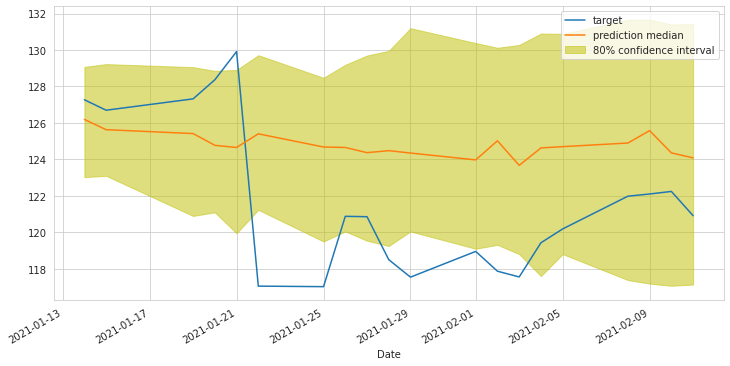

In [564]:
# display predictions
display_quantiles(d_single_prediction, prediction_length[1], test_gt)

### Predicting Apple stock price

Ground truth:

In [583]:
test_gt = df_aapl_test.iloc[-prediction_length[1]:]['Adj Close']

In [584]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_aapl_train]
target_ts = [df_aapl]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)

In [585]:
json_prediction[0]

,0.1,0.9,0.5
2021-01-14,126.687981,136.694641,131.830551
2021-01-15,125.907822,136.288162,131.779892
2021-01-16,127.257195,137.156067,132.203171
2021-01-17,126.875504,137.562775,131.642197
2021-01-18,127.086014,137.864471,132.795532
2021-01-19,125.682129,139.646515,133.195480
2021-01-20,126.429367,140.495224,132.151886
2021-01-21,125.804688,140.866043,132.957031
2021-01-22,126.165352,140.593033,133.681732
2021-01-23,125.620262,142.164536,133.780518


As we can see, index are just progressing of one day each row, wich is not stock price progression scheme in real life (e.g.: weekends are not trading days), so I'm going fix the index before going on with the analysis of results:

In [586]:
single_prediction = json_prediction[0]

In [587]:
single_prediction.index = test_gt.index

Save data locally:

In [588]:
data_dir_json_prediction = os.path.join(data_dir_json_dyn_feat, 'prediction') # The folder we will use for storing data
if not os.path.exists(data_dir_json_prediction): # Make sure that the folder exists
    os.makedirs(data_dir_json_prediction)

In [589]:
start_date = str(single_prediction.index[0].date())
end_date = str(single_prediction.index[-1].date())

Prediction serialization:

In [590]:
single_prediction.to_json(os.path.join(data_dir_json_prediction, "AAPL_{} - {}.json".format(start_date, end_date)),
                          orient='columns',date_format='iso')

Prediction de-serialization:

In [591]:
d_single_prediction = pd.read_json(os.path.join(data_dir_json_prediction, "AAPL_{} - {}.json".format(start_date, end_date)),
                                   orient='columns', convert_axes=False)

Again, index normalization using target index, before using deserialized data:

In [592]:
d_single_prediction.index = test_gt.index

#### Metrics computation

Mean Absolute Error

In [593]:
aapl_dar_mae_loss = mean_absolute_error(test_gt, json_prediction[0]['0.5'])

In [594]:
print(aapl_dar_mae_loss)

3.4083789825473856


Root Mean Squared Error

In [595]:
aapl_dar_mse_loss = mean_squared_error(test_gt, json_prediction[0]['0.5'], squared=False)

In [596]:
print(aapl_dar_mse_loss)

4.572659194842066


Mean Absolute Percentage Error

In [597]:
aapl_dar_map_loss = mean_absolute_percentage_error(test_gt, json_prediction[0]['0.5'])

In [598]:
print(aapl_dar_map_loss)

0.024839591845465928


R<sup>2</sup> score

In [599]:
aapl_dar_r2_score = r2_score(test_gt, json_prediction[0]['0.5'])

In [600]:
print(aapl_dar_r2_score)

-0.09221849220360889


## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.

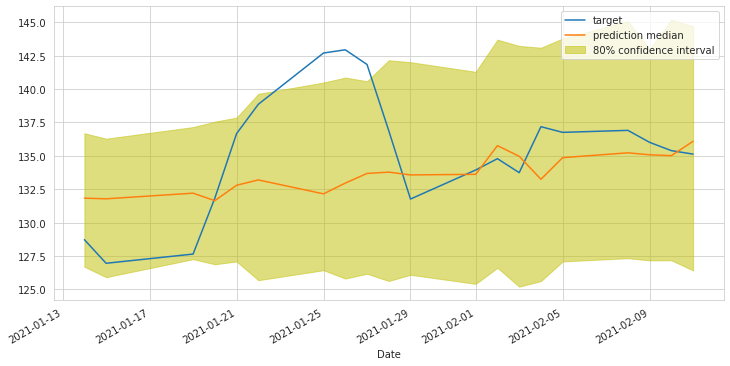

In [601]:
# display predictions
display_quantiles(d_single_prediction, prediction_length[1], test_gt)

### Predicting Amazon stock price

Ground truth:

In [649]:
test_gt = df_amzn_test.iloc[-prediction_length[1]:]['Adj Close']

In [650]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_amzn_train]
target_ts = [df_amzn]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)

In [651]:
json_prediction[0]

,0.1,0.9,0.5
2021-01-14,3083.363770,3243.973145,3165.852783
2021-01-15,3089.705078,3258.393311,3151.550537
2021-01-16,3101.117676,3260.151611,3176.085205
2021-01-17,3098.940674,3316.961182,3176.912598
2021-01-18,3082.963867,3298.573975,3176.183350
2021-01-19,3078.840088,3338.562744,3203.579346
2021-01-20,3101.420410,3320.873535,3193.423828
2021-01-21,3095.966064,3304.049072,3212.581299
2021-01-22,3141.734131,3365.900146,3231.217529
2021-01-23,3118.779053,3367.672119,3231.550293


As we can see, index are just progressing of one day each row, wich is not stock price progression scheme in real life (e.g.: weekends are not trading days), so I'm going fix the index before going on with the analysis of results:

In [652]:
single_prediction = json_prediction[0]

In [653]:
single_prediction.index = test_gt.index

Save data locally:

In [654]:
data_dir_json_prediction = os.path.join(data_dir_json_dyn_feat, 'prediction') # The folder we will use for storing data
if not os.path.exists(data_dir_json_prediction): # Make sure that the folder exists
    os.makedirs(data_dir_json_prediction)

In [655]:
start_date = str(single_prediction.index[0].date())
end_date = str(single_prediction.index[-1].date())

Prediction serialization:

In [656]:
single_prediction.to_json(os.path.join(data_dir_json_prediction, "AMZN_{} - {}.json".format(start_date, end_date)),
                          orient='columns',date_format='iso')

Prediction de-serialization:

In [657]:
d_single_prediction = pd.read_json(os.path.join(data_dir_json_prediction, "AMZN_{} - {}.json".format(start_date, end_date)),
                                   orient='columns', convert_axes=False)

Again, index normalization using target index, before using deserialized data:

In [658]:
d_single_prediction.index = test_gt.index

#### Metrics computation

Mean Absolute Error

In [659]:
amzn_dar_mae_loss = mean_absolute_error(test_gt, json_prediction[0]['0.5'])

In [660]:
print(amzn_dar_mae_loss)

71.33604736328876


Root Mean Squared Error

In [661]:
amzn_dar_mse_loss = mean_squared_error(test_gt, json_prediction[0]['0.5'], squared=False)

In [662]:
print(amzn_dar_mse_loss)

81.88947056372787


Mean Absolute Percentage Error

In [663]:
amzn_dar_map_loss = mean_absolute_percentage_error(test_gt, json_prediction[0]['0.5'])

In [664]:
print(amzn_dar_map_loss)

0.021641921031021413


R<sup>2</sup> score

In [665]:
amzn_dar_r2_score = r2_score(test_gt, json_prediction[0]['0.5'])

In [666]:
print(amzn_dar_r2_score)

-0.15355724334036536


## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.

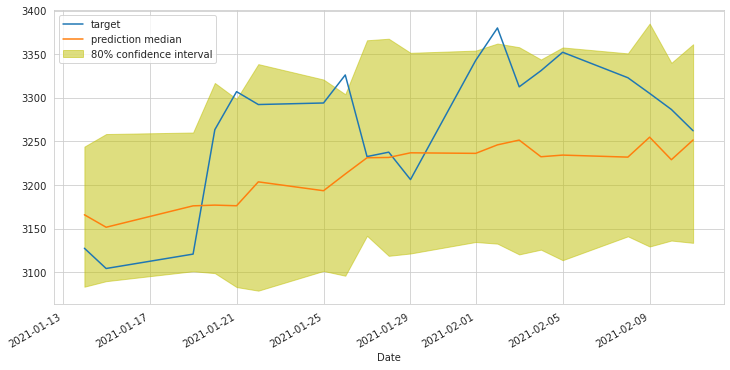

In [667]:
# display predictions
display_quantiles(d_single_prediction, prediction_length[1], test_gt)

### Predicting Alphabet stock price

Ground truth:

In [668]:
test_gt = df_googl_test.iloc[-prediction_length[1]:]['Adj Close']

In [669]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_googl_train]
target_ts = [df_googl]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)

In [670]:
json_prediction[0]

,0.1,0.9,0.5
2021-01-14,1709.869507,1791.522217,1752.628174
2021-01-15,1710.692139,1793.002686,1744.651001
2021-01-16,1683.686035,1789.733032,1742.862183
2021-01-17,1688.041016,1788.531006,1736.221802
2021-01-18,1683.473877,1794.115601,1740.574463
2021-01-19,1693.244873,1804.287231,1750.267334
2021-01-20,1682.002319,1797.195679,1744.346558
2021-01-21,1690.161011,1805.203613,1746.969482
2021-01-22,1695.808960,1818.132446,1754.568237
2021-01-23,1699.256836,1825.712646,1760.087646


As we can see, index are just progressing of one day each row, wich is not stock price progression scheme in real life (e.g.: weekends are not trading days), so I'm going fix the index before going on with the analysis of results:

In [671]:
single_prediction = json_prediction[0]

In [672]:
single_prediction.index = test_gt.index

Save data locally:

In [673]:
data_dir_json_prediction = os.path.join(data_dir_json_dyn_feat, 'prediction') # The folder we will use for storing data
if not os.path.exists(data_dir_json_prediction): # Make sure that the folder exists
    os.makedirs(data_dir_json_prediction)

In [674]:
start_date = str(single_prediction.index[0].date())
end_date = str(single_prediction.index[-1].date())

Prediction serialization:

In [675]:
single_prediction.to_json(os.path.join(data_dir_json_prediction, "GOOGL_{} - {}.json".format(start_date, end_date)),
                          orient='columns',date_format='iso')

Prediction de-serialization:

In [676]:
d_single_prediction = pd.read_json(os.path.join(data_dir_json_prediction, "GOOGL_{} - {}.json".format(start_date, end_date)),
                                   orient='columns', convert_axes=False)

Again, index normalization using target index, before using deserialized data:

In [677]:
d_single_prediction.index = test_gt.index

#### Metrics computation

Mean Absolute Error

In [679]:
googl_dar_mae_loss = mean_absolute_error(test_gt, json_prediction[0]['0.5'])

In [680]:
print(googl_dar_mae_loss)

168.39111328125563


Root Mean Squared Error

In [682]:
googl_dar_mse_loss = mean_squared_error(test_gt, json_prediction[0]['0.5'], squared=False)

In [683]:
print(googl_dar_mse_loss)

195.96863100967352


Mean Absolute Percentage Error

In [684]:
googl_dar_map_loss = mean_absolute_percentage_error(test_gt, json_prediction[0]['0.5'])

In [685]:
print(googl_dar_map_loss)

0.0844669607136527


R<sup>2</sup> score

In [686]:
googl_dar_r2_score = r2_score(test_gt, json_prediction[0]['0.5'])

In [687]:
print(googl_dar_r2_score)

-1.6351026552810661


## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.

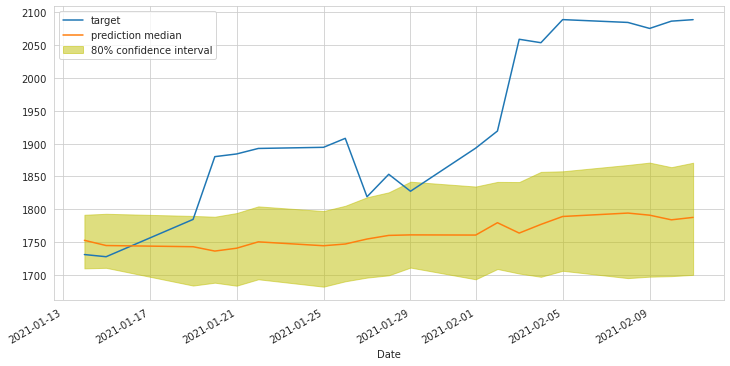

In [688]:
# display predictions
display_quantiles(d_single_prediction, prediction_length[1], test_gt)

## Delete the Endpoint

Try your code out on different time series. You may want to tweak your DeepAR hyperparameters and see if you can improve the performance of this predictor.

When you're done with evaluating the predictor (any predictor), make sure to delete the endpoint.

In [693]:
## TODO: delete the endpoint
json_predictor.delete_endpoint()